### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [36]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-11-11 11:12:13--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Распознаётся ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)… 130.14.250.12, 130.14.250.10
Подключение к ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1168222 (1,1M) [application/x-gzip]
Сохранение в: «GCF_000355675.1_ASM35567v1_genomic.fna.gz»

GCF_000355675.1_ASM 100%[===================>]   1,11M  1,18MB/s    за 0,9s    

2022-11-11 11:12:15 (1,18 MB/s) - «GCF_000355675.1_ASM35567v1_genomic.fna.gz» сохранён [1168222/1168222]

--2022-11-11 11:12:16--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Распознаётся ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)… 130.14.250.10, 130.14.250.12
Подключение к ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... сое

### Reading sequences

In [37]:
!pip3 install bio

In [38]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("../data/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('../data/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [39]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [40]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [41]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [42]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [43]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


TATTACTTC

In [44]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.800850646089566e-06

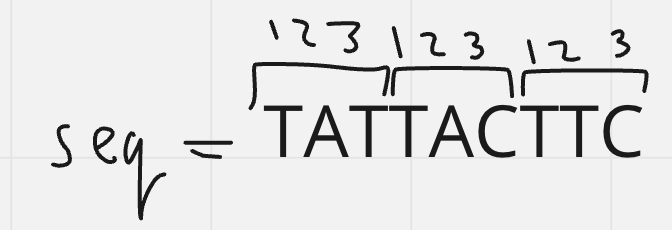

In [45]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.933667623206424e-07

In [46]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8285589420792552

In [47]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.1714410579207448

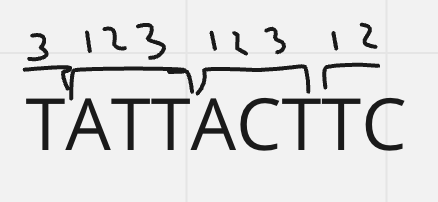

In [48]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.397316710439334e-06

### Prediction

In [49]:
def cod_proba(seq, t1, t2, frame=1):
  
  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  prev_nuc = seq[0]
  start_pos = 1
  
  log_prob = np.log(t1['pos1'][seq[0]])
  cur_pos = 1
  if frame == 2:
    log_prob = np.log(t1['pos3'][seq[0]])
    cur_pos = 3
  elif frame == 3:
    log_prob = np.log(t1['pos2'][seq[0]])
    cur_pos = 2

  for i, nuc in enumerate(seq[1:], start_pos):
    cur_pos = max(1, (cur_pos + 1) % 4)
    pos = f'pos{cur_pos}'
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[pos][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
  if len(seq) == 0:
    print('No sequence')
    return None

  prev_nuc = seq[0]
  log_prob = np.log(t1['nc'][prev_nuc])
  for i, nuc in enumerate(seq[1:]):
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2['nc'][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
  prob1 = cod_proba(seq, t1, t2, frame=1)
  prob2 = cod_proba(seq, t1, t2, frame=2)
  prob3 = cod_proba(seq, t1, t2, frame=3)
  probnc = ncod_proba(seq, t1, t2)
  total = prob1 + prob2 + prob3 + probnc
  return prob1 / total, prob2 / total, prob3 / total, probnc / total

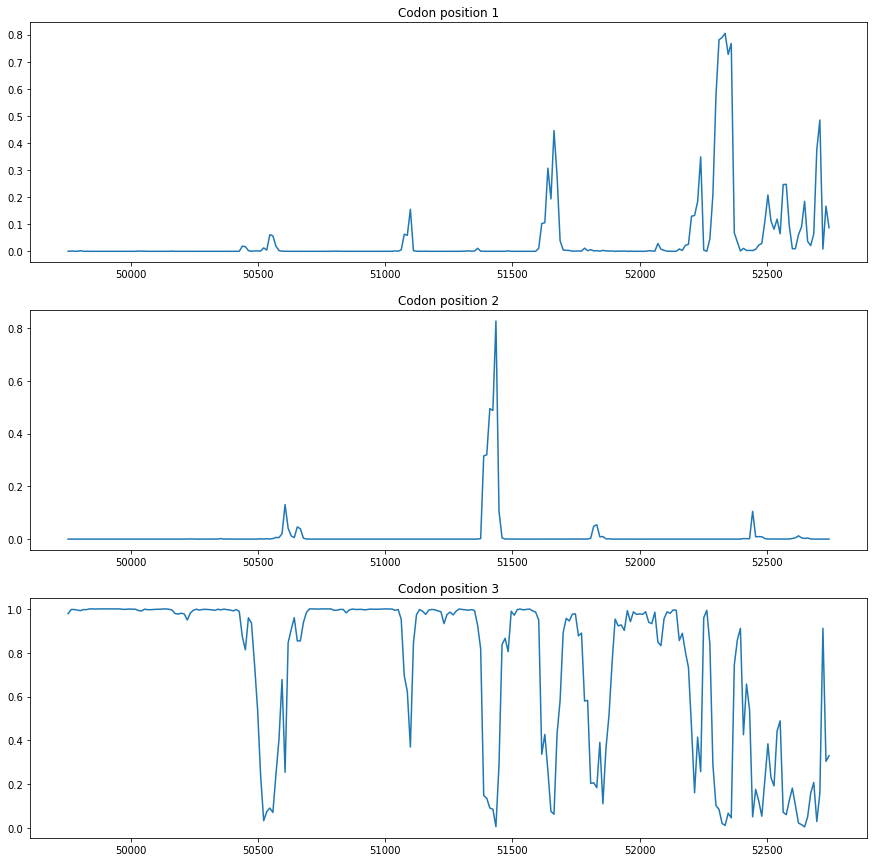

In [50]:
def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

  x = range(start, end, step)

  ax1.plot(x, data[:, 0])
  ax2.plot(x, data[:, 1])
  ax3.plot(x, data[:, 2])

  ax1.set_title('Codon position 1')
  ax2.set_title('Codon position 2')
  ax3.set_title('Codon position 3')

  plt.plot()


start = 49755
end = start + 3000
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
  pos_probs.append(get_cod_probs(seq[i: i + window], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph(pos_probs, start, end, step)